# Think Bayes: Chapter 3

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import thinkplot
from thinkbayes2 import Hist, Pmf, Suite, Cdf

## The Dice problem

Suppose I have a box of dice that contains a 4-sided die, a 6-sided
die, an 8-sided die, a 12-sided die, and a 20-sided die.

I select a die from the box at random, roll it, and get a 6.
What is the probability that I rolled each die?

The `Dice` class inherits `Update` and provides `Likelihood`

In [2]:
class Dice(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1/hypo

Here's what the update looks like:

In [3]:
suite = Dice([4, 6, 8, 12, 20])
suite.Update(6)
suite.Print()

4 0.0
6 0.3921568627450981
8 0.29411764705882354
12 0.19607843137254904
20 0.11764705882352944


And here's what it looks like after more data:

In [4]:
for roll in [6, 8, 7, 7, 5, 4]:
        suite.Update(roll)
        
suite.Print()

4 0.0
6 0.0
8 0.9432484536722124
12 0.0552061280612909
20 0.001545418266496554


## The train problem

The Train problem has the same likelihood as the Dice problem.

In [5]:
class Train(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1/hypo

But there are many more hypotheses

In [6]:
hypos = range(1, 1001)
suite = Train(hypos)
suite.Update(60)

0.0028222671142652746

Here's what the posterior looks like

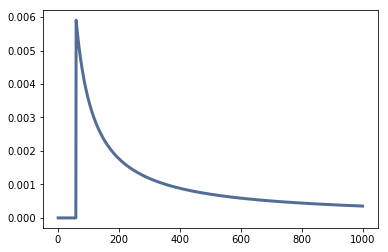

In [7]:
thinkplot.Pdf(suite)

And here's how we can compute the posterior mean

In [8]:
def Mean(suite):
    total = 0
    for hypo, prob in suite.Items():
        total += hypo * prob
    return total

Mean(suite)

333.41989326371095

Or we can just use the method

In [9]:
suite.Mean()

333.41989326371095

## Sensitivity to the prior

Here's a function that solves the train problem for different priors and data

In [10]:
def MakePosterior(high, dataset, constructor=Train):
    """Solves the train problem.
    
    high: int maximum number of trains
    dataset: sequence of observed train numbers
    constructor: function used to construct the Train object
    
    returns: Train object representing the posterior suite
    """
    hypos = range(1, high+1)
    suite = constructor(hypos)

    for data in dataset:
        suite.Update(data)

    return suite

Let's run it with the same dataset and several uniform priors

In [11]:
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    suite = MakePosterior(high, dataset)
    print(high, suite.Mean())

500 151.84958795903822
1000 164.30558642273363
2000 171.33818109150937


The results are quite sensitive to the prior, even with several observations.

## Power law prior

Now let's try it with a power law prior.

In [12]:
class Train2(Train):

    def __init__(self, hypos, alpha=1.0):
        Pmf.__init__(self)
        for hypo in hypos:
            self[hypo] = hypo**(-alpha)
        self.Normalize()

Here's what a power law prior looks like, compared to a uniform prior

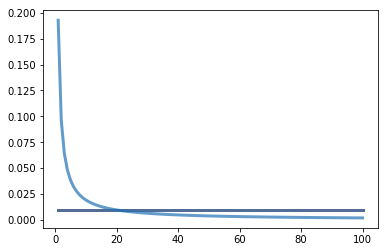

In [13]:
high = 100
hypos = range(1, high+1)
suite1 = Train(hypos)
suite2 = Train2(hypos)
thinkplot.Pdf(suite1)
thinkplot.Pdf(suite2)

Now let's see what the posteriors look like after observing one train.

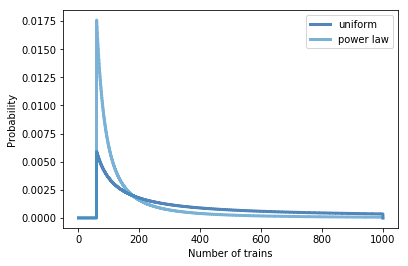

In [14]:
dataset = [60]
high = 1000

thinkplot.PrePlot(num=2)

constructors = [Train, Train2]
labels = ['uniform', 'power law']

for constructor, label in zip(constructors, labels):
    suite = MakePosterior(high, dataset, constructor)
    suite.label = label
    thinkplot.Pmf(suite)

thinkplot.Config(xlabel='Number of trains',
                 ylabel='Probability')

The power law gives less prior probability to high values, which yields lower posterior means, and less sensitivity to the upper bound.

In [15]:
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    suite = MakePosterior(high, dataset, Train2)
    print(high, suite.Mean())

500 130.70846986256004
1000 133.2752313750312
2000 133.99746308073065


## Credible intervals

To compute credible intervals, we can use the `Percentile` method on the posterior.

In [16]:
hypos = range(1, 1001)
suite = Train(hypos)
suite.Update(60)

suite.Percentile(5), suite.Percentile(95)

(69, 869)

If you have to compute more than a few percentiles, it is more efficient to compute a CDF.

Also, a CDF can be a better way to visualize distributions.

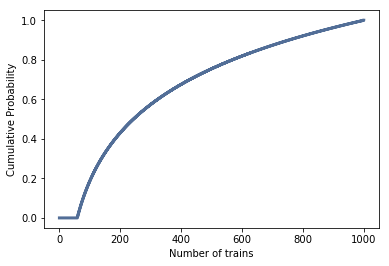

In [17]:
cdf = Cdf(suite)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Number of trains',
                 ylabel='Cumulative Probability',
                 legend=False)

`Cdf` also provides `Percentile`

In [18]:
cdf.Percentile(5), cdf.Percentile(95)

(69, 869)

## Exercises

**Exercise:** To write a likelihood function for the locomotive problem, we had
to answer this question:  "If the railroad has `N` locomotives, what
is the probability that we see number 60?"

The answer depends on what sampling process we use when we observe the
locomotive.  In the book, I resolved the ambiguity by specifying
that there is only one train-operating company (or only one that we
care about).

But suppose instead that there are many companies with different
numbers of trains.  And suppose that you are equally likely to see any
train operated by any company.
In that case, the likelihood function is different because you
are more likely to see a train operated by a large company.

As an exercise, implement the likelihood function for this variation
of the locomotive problem, and compare the results.

In [19]:
# for this solution, I'm assuming there are 1000 companies with equal probability of having 1-1000 trains.
# I'm assuming if hypo=1 this corresponds to company 1 having 1 train, hypo=2 company 2 has 2 trains, hypo=3 company
# 3 has 3 trains ...
class Train3(Train):

    def __init__(self, hypos, alpha=1.0):
        Pmf.__init__(self)
        total_num_trains = sum(hypos) #calculating the total number of trains
        for hypo in hypos:
            self[hypo] = hypo/total_num_trains # equivalent to the PMF(x) = x/(sum of all locomotives)
        self.Normalize()

In [24]:
high=1000
dataset = [30,60,90]
suite = MakePosterior(high, dataset, constructor=Train3)
print(high, suite.Mean())

1000 237.28267004125604


In [25]:
high=2000
dataset = [30,60,90]
suite = MakePosterior(high, dataset, constructor=Train3)
print(high, suite.Mean())

2000 291.09457514535836
